## Ex3 - Autoencoders

In [1]:
%matplotlib inline

import helper
import network_utils
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Consts

In [2]:
CIFAR_10_DATASET_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
CIFAR_10_DATASET_FOLDER_PATH = 'cifar-10-batches-py'
TAR_GZ_PATH = 'cifar-10-python.tar.gz'
SAVE_MODEL_PATH = './model'

NOISE_FACTOR = 5
N_BATCHES = 5

### Hyperparameters

In [3]:
epochs = 100
batch_size = 2000
learning_rate = 0.001
show_images_every_n_epochs = 5
keep_probability = 0.8

# TODO - remove this
do_preprocess = False

## Denoising Autoencoder

### Prepare the dataset

In [4]:
helper.download_dataset(CIFAR_10_DATASET_URL, CIFAR_10_DATASET_FOLDER_PATH, TAR_GZ_PATH) 
if do_preprocess:
    helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, N_BATCHES)
    
images, _ = helper.load_cfar10_batch(CIFAR_10_DATASET_FOLDER_PATH, random.randint(1, N_BATCHES))
valid_features, valid_noisy, valid_labels = helper.load_preprocess_validation()[:10]
test_features, test_noisy, test_labels = helper.load_preprocess_testing()

Cifar-10 dataset found


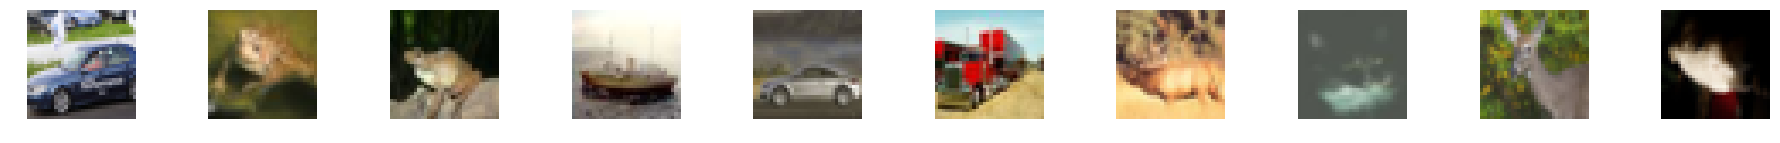

In [5]:
plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(images[i + random.randint(0, len(images) - 10)])

### Build the network

In [6]:
inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3))
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3))
labels_ = tf.placeholder(tf.float32, [None, 10])

In [7]:
encoder = tf.layers.conv2d(inputs_, 12, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 48, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 192, [5, 5], strides=(4, 4), padding="SAME")

decoder = tf.layers.conv2d_transpose(encoder, 192, [5, 5], strides=(4, 4), padding="SAME")
decoder = network_utils.unpool(decoder)
decoder = tf.layers.conv2d_transpose(decoder, 48, [5, 5], strides=(1, 1), padding="SAME")
decoder = network_utils.unpool(decoder)
decoder = tf.layers.conv2d_transpose(decoder, 3, [5, 5], strides=(1, 1), padding="SAME")

y_pred = tf.identity(decoder)
cost = tf.reduce_mean(tf.abs(y_pred - targets_))
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Build the classifier

In [8]:
keep_prob = tf.placeholder(tf.float32)

logits = network_utils.build_classification_network(encoder, keep_prob)
logits = tf.identity(logits)

classifier_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
classifier_opt = tf.train.AdamOptimizer(learning_rate).minimize(classifier_cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Train the network

In [9]:
sess = tf.Session()

Training...
('Epoch: 1/20...', 'Training loss: 0.1580')
('Epoch: 2/20...', 'Training loss: 0.1185')
('Epoch: 3/20...', 'Training loss: 0.0991')
('Epoch: 4/20...', 'Training loss: 0.0910')
('Epoch: 5/20...', 'Training loss: 0.0856')
('Epoch: 6/20...', 'Training loss: 0.0806')
('Epoch: 7/20...', 'Training loss: 0.0777')
('Epoch: 8/20...', 'Training loss: 0.0759')
('Epoch: 9/20...', 'Training loss: 0.0736')
('Epoch: 10/20...', 'Training loss: 0.0743')
('Epoch: 11/20...', 'Training loss: 0.0702')
('Epoch: 12/20...', 'Training loss: 0.0717')
('Epoch: 13/20...', 'Training loss: 0.0681')
('Epoch: 14/20...', 'Training loss: 0.0686')
('Epoch: 15/20...', 'Training loss: 0.0678')
('Epoch: 16/20...', 'Training loss: 0.0663')
('Epoch: 17/20...', 'Training loss: 0.0651')
('Epoch: 18/20...', 'Training loss: 0.0668')
('Epoch: 19/20...', 'Training loss: 0.0649')
('Epoch: 20/20...', 'Training loss: 0.0639')


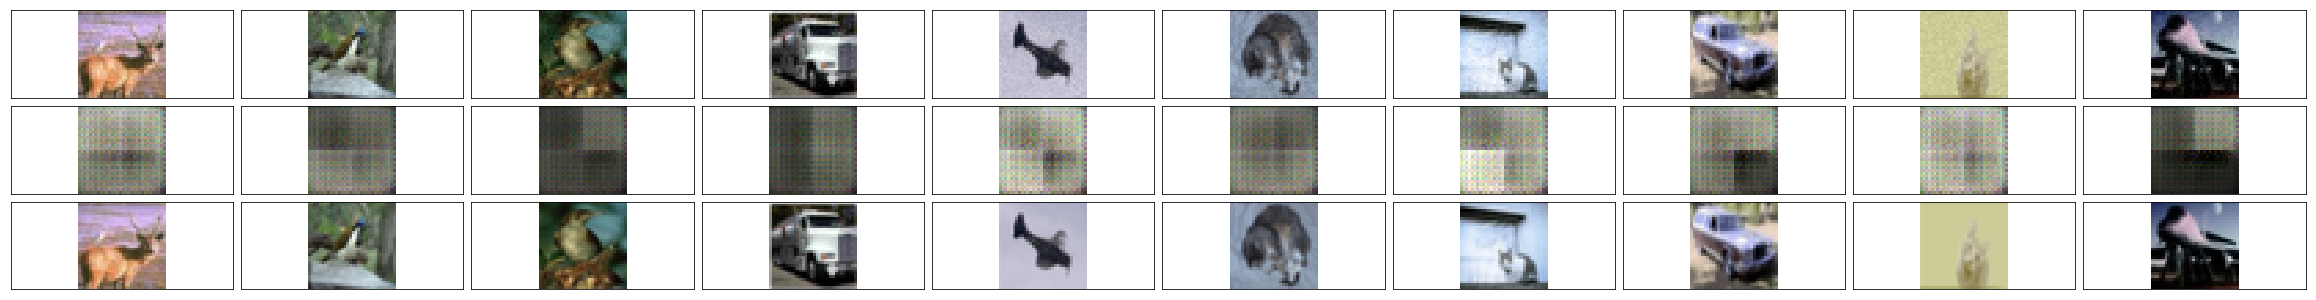

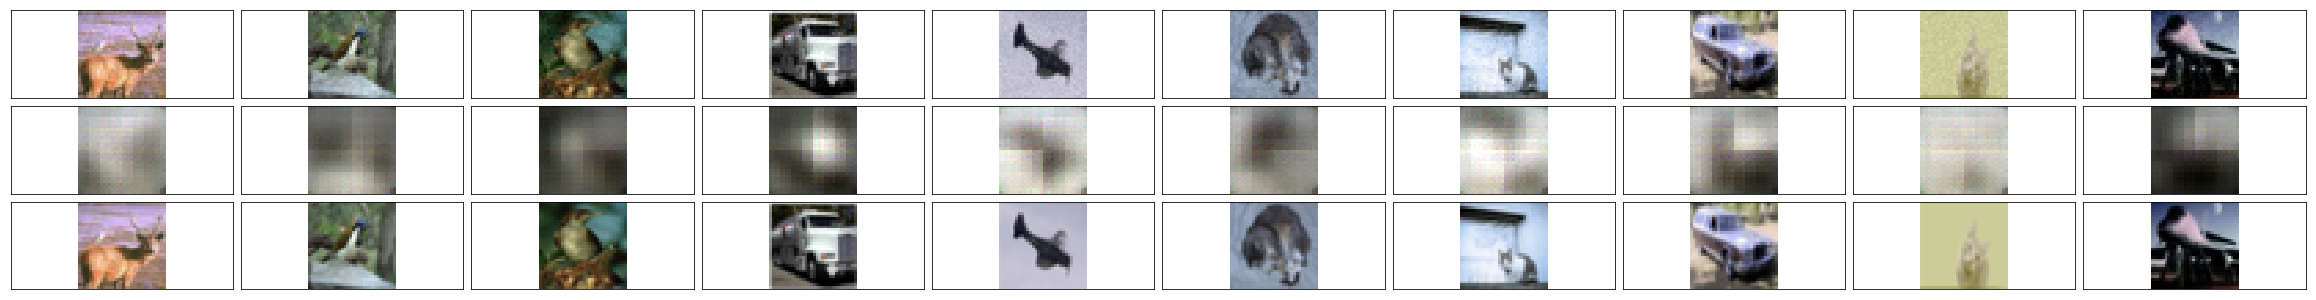

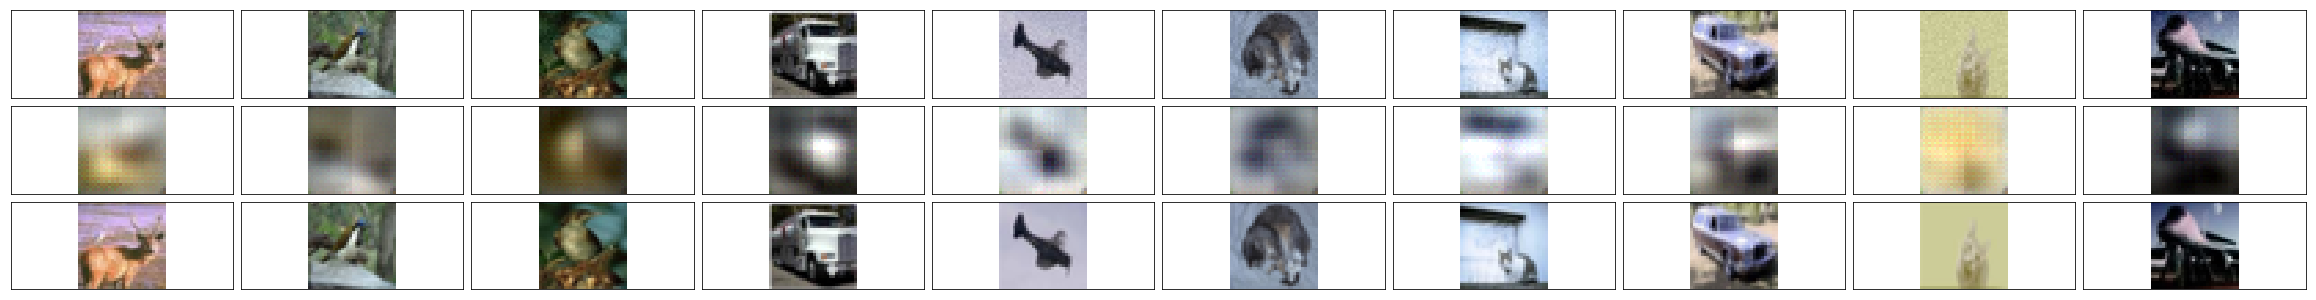

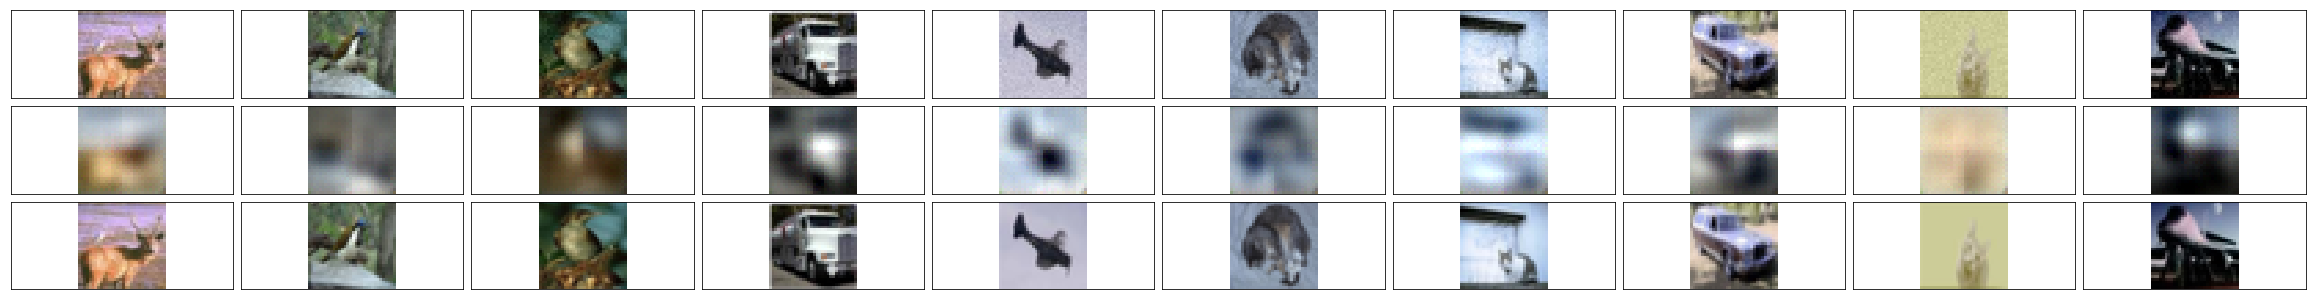

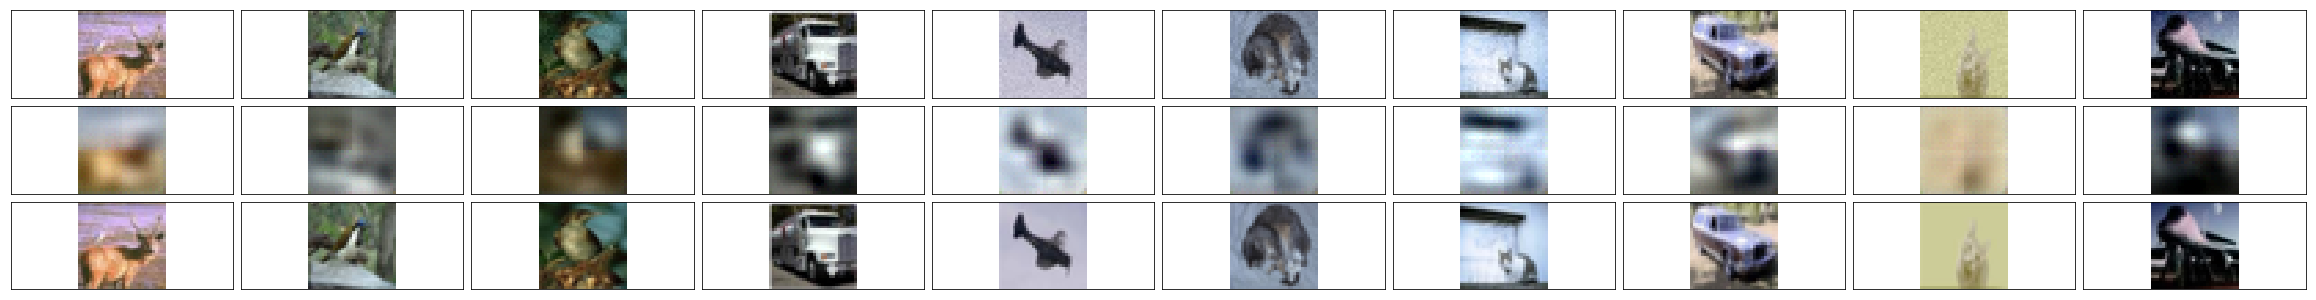

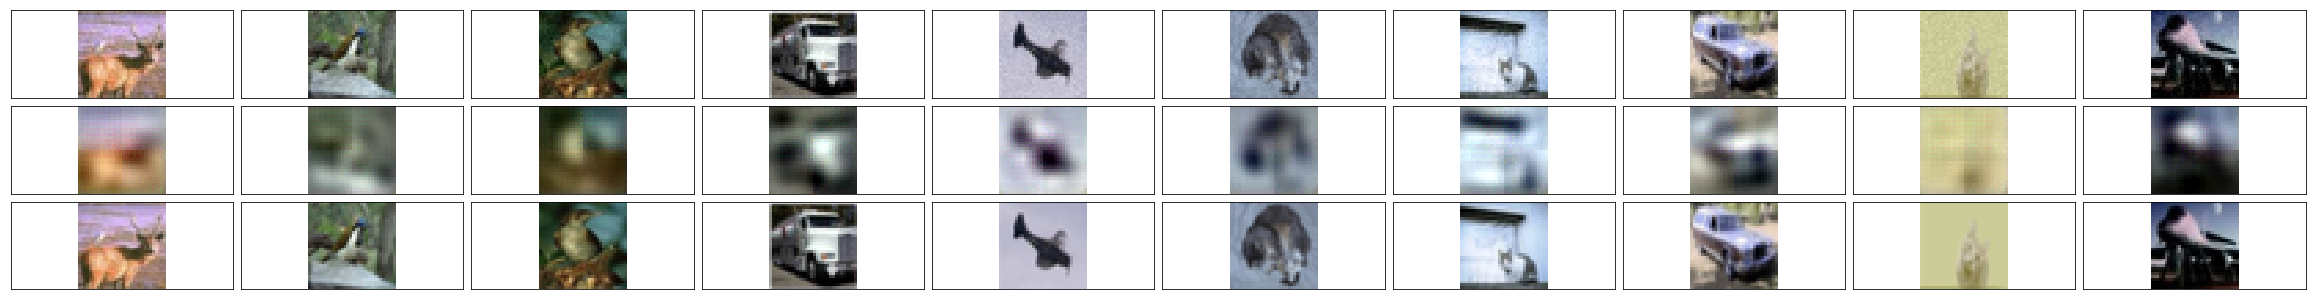

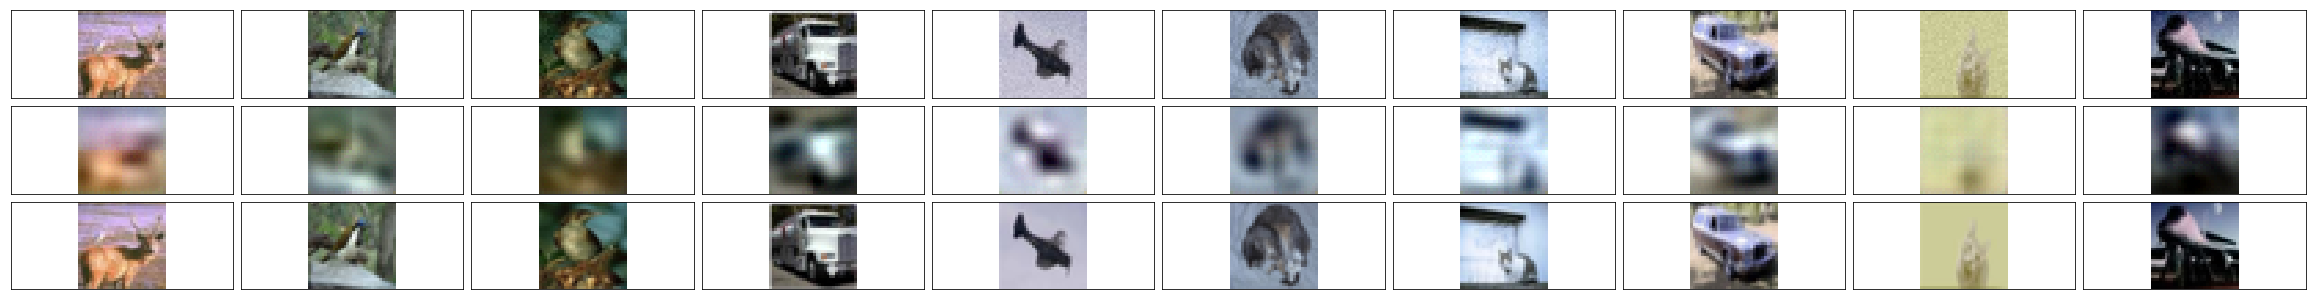

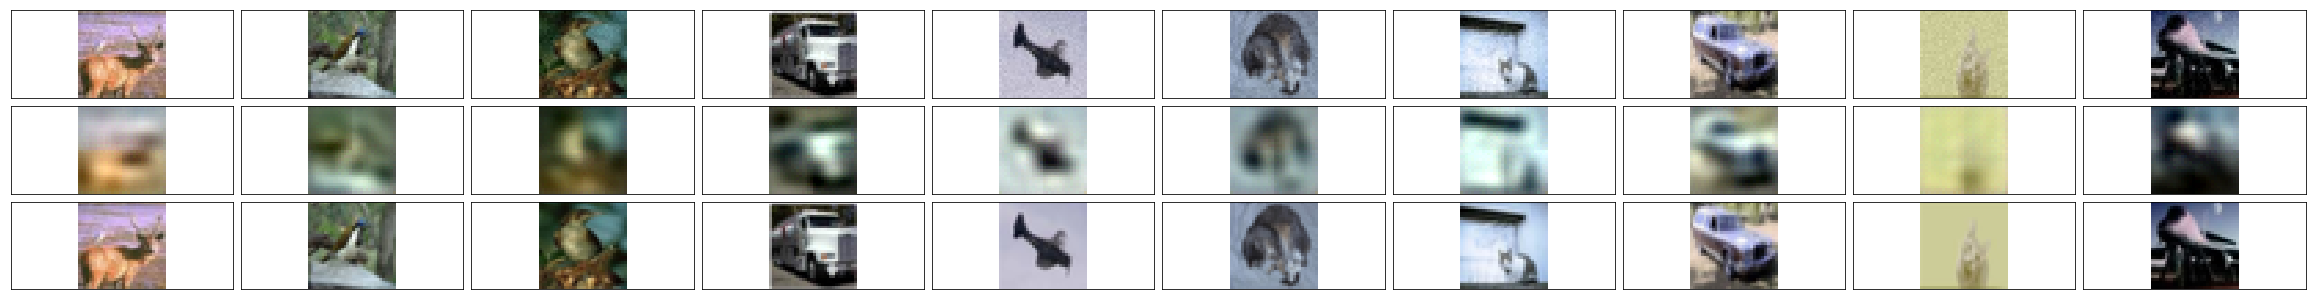

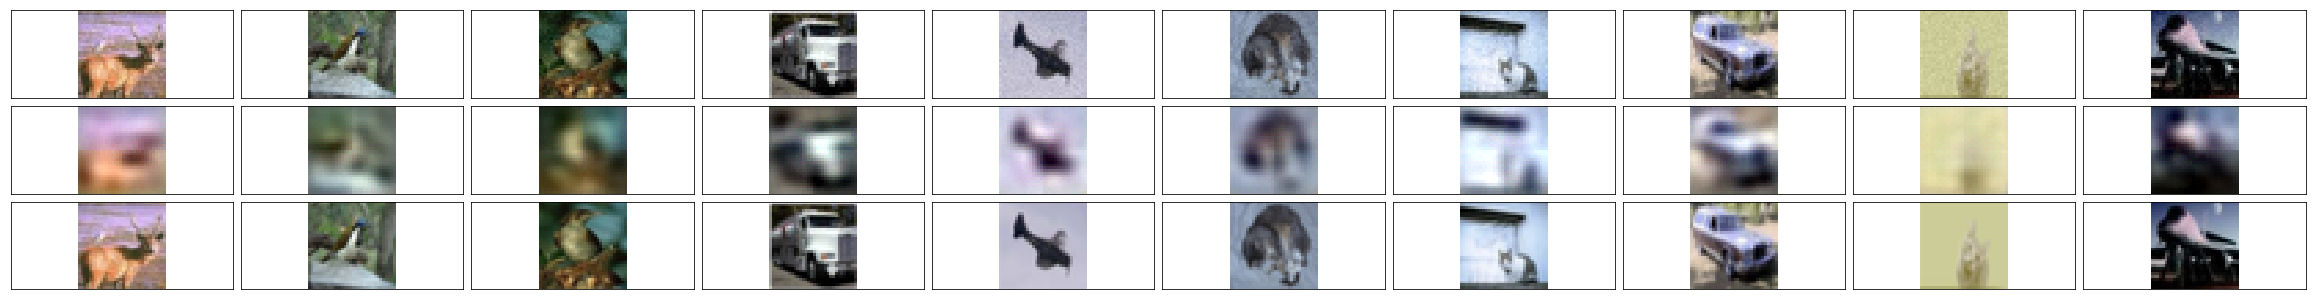

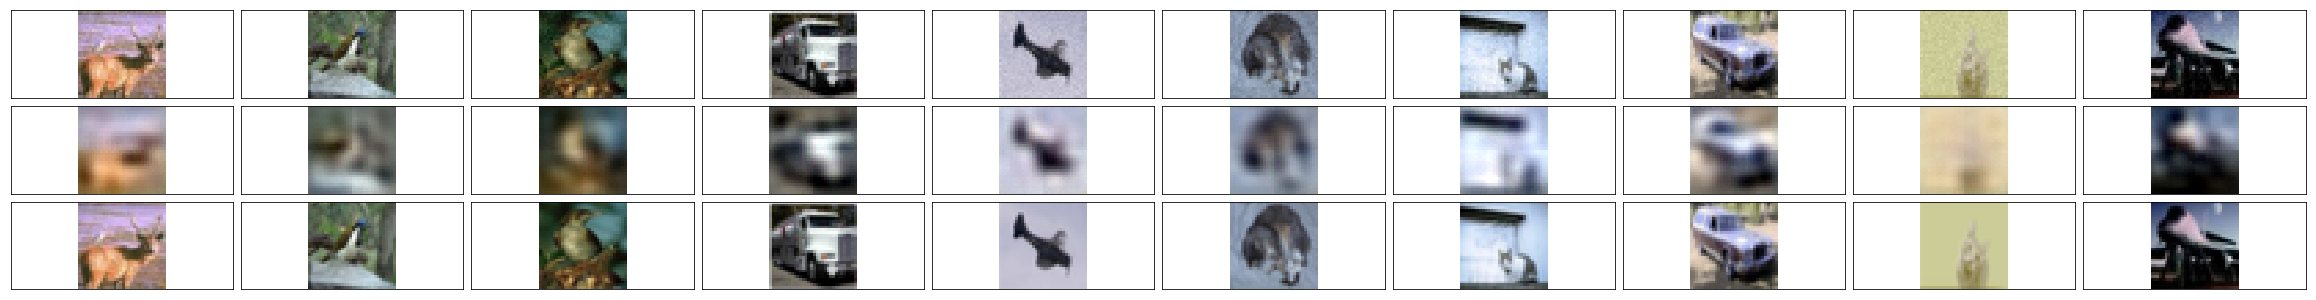

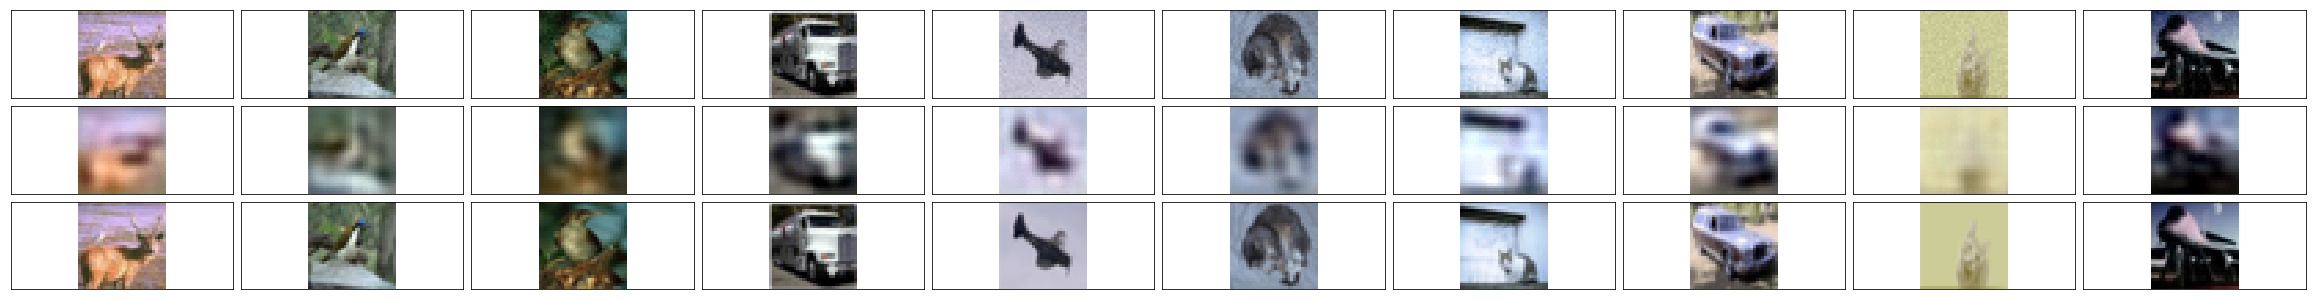

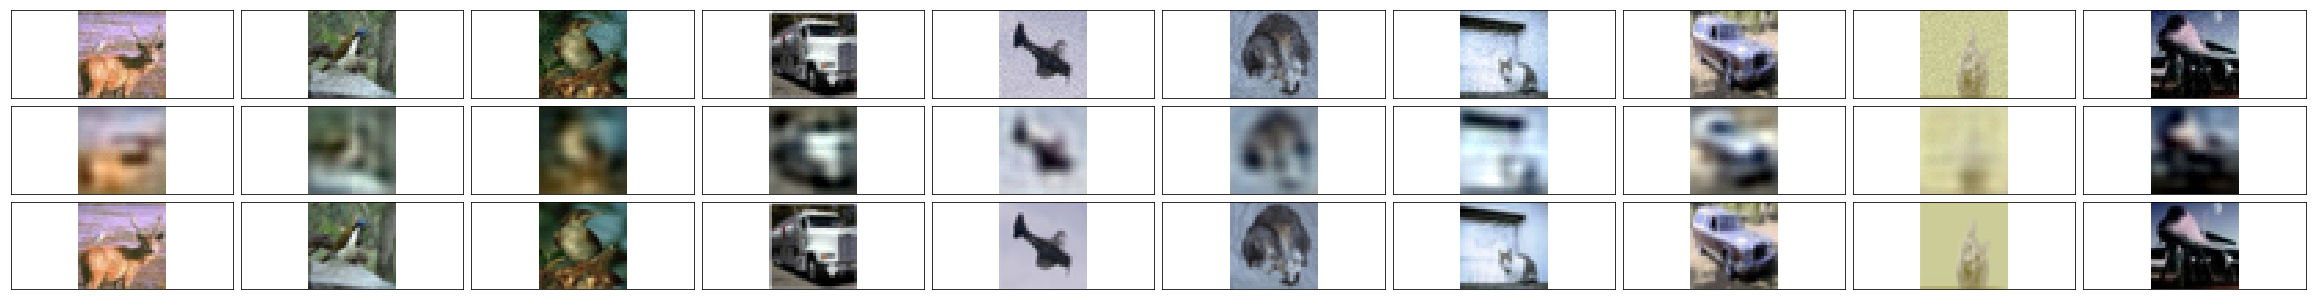

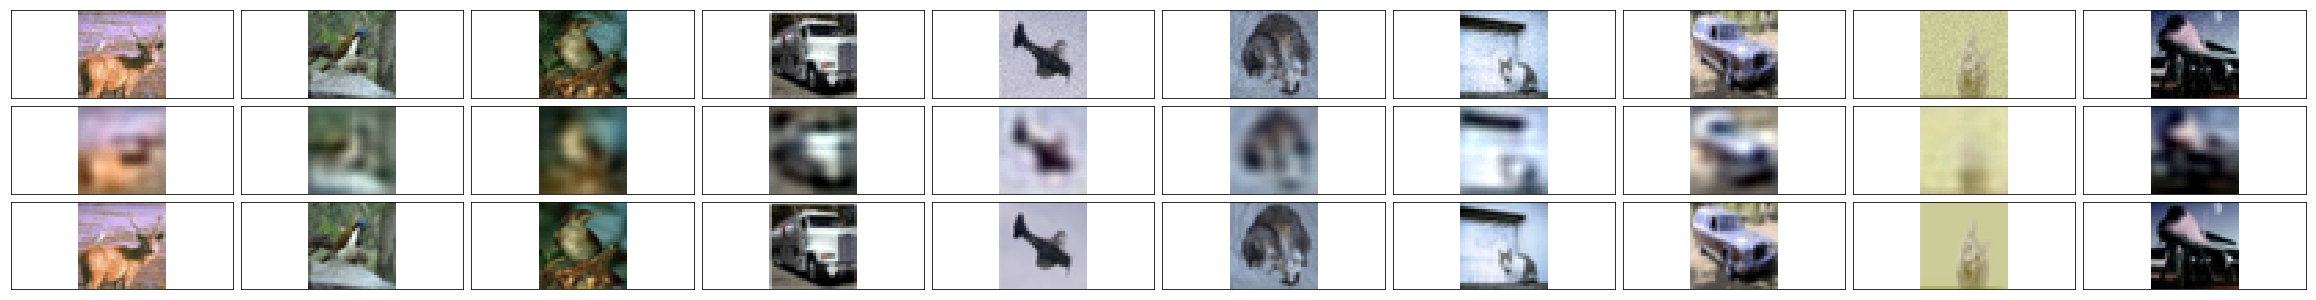

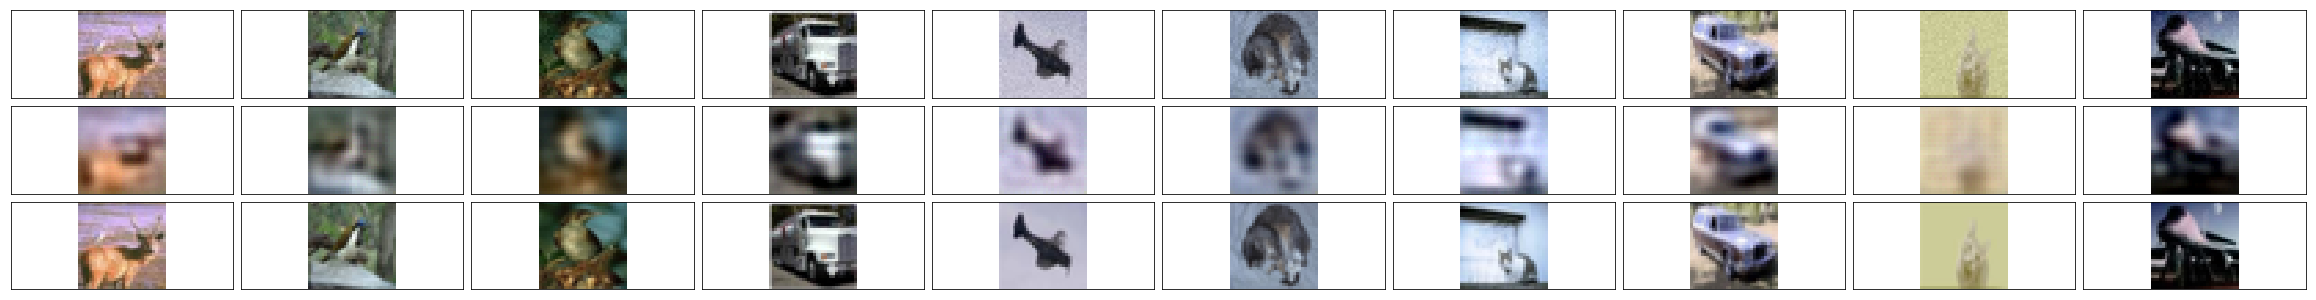

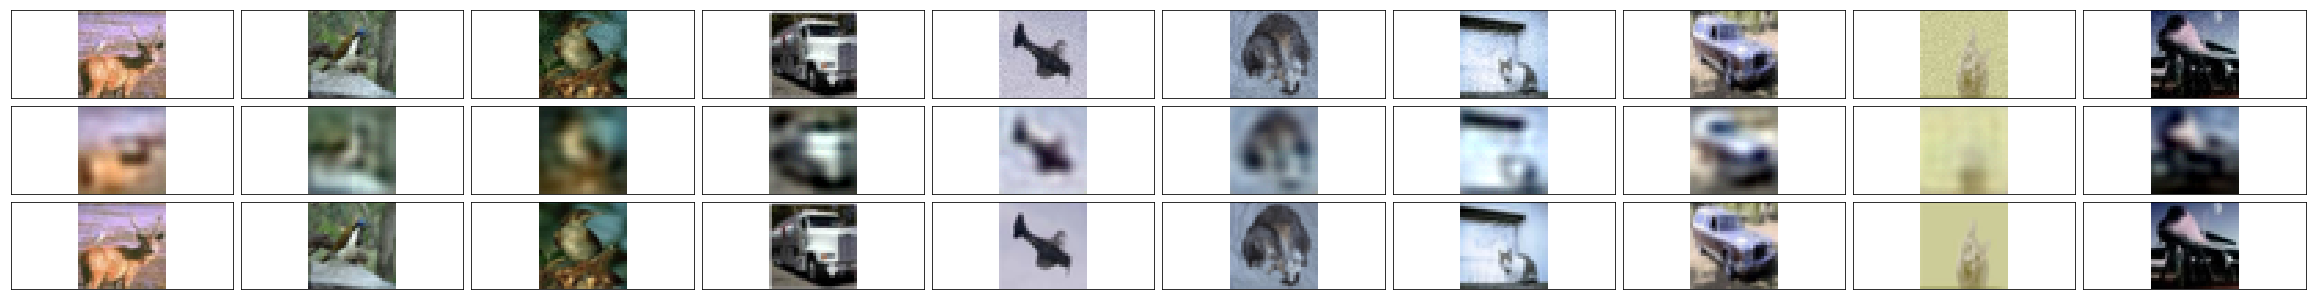

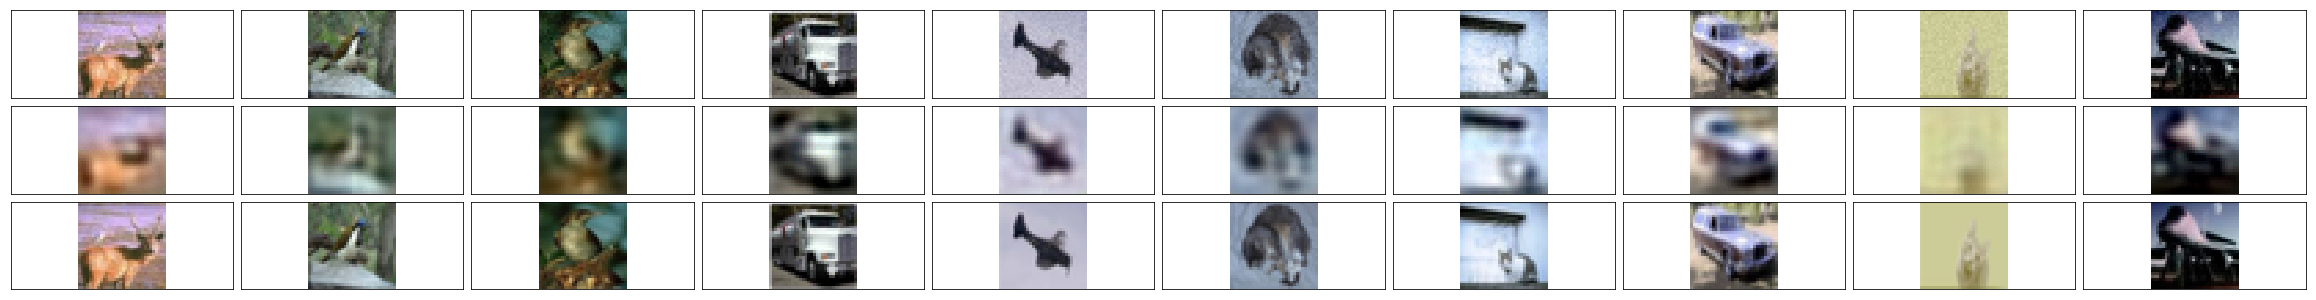

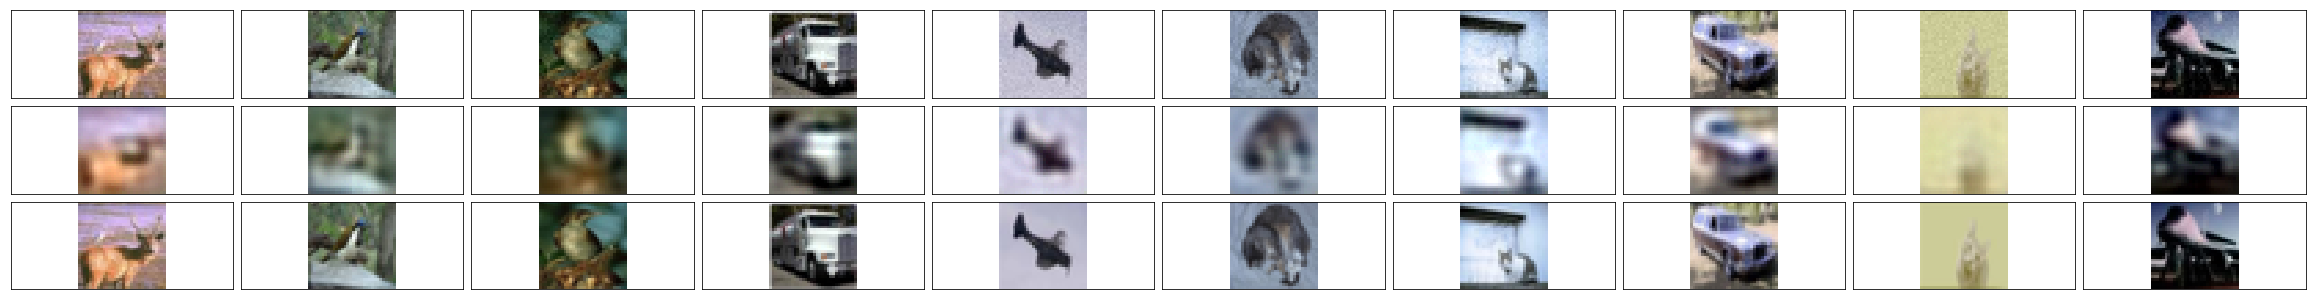

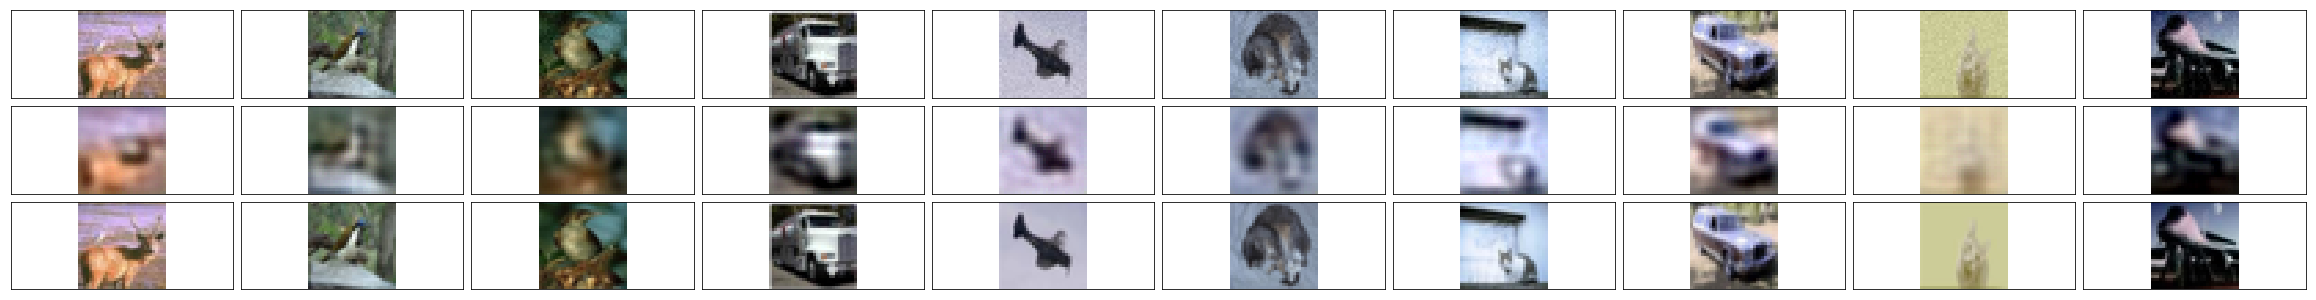

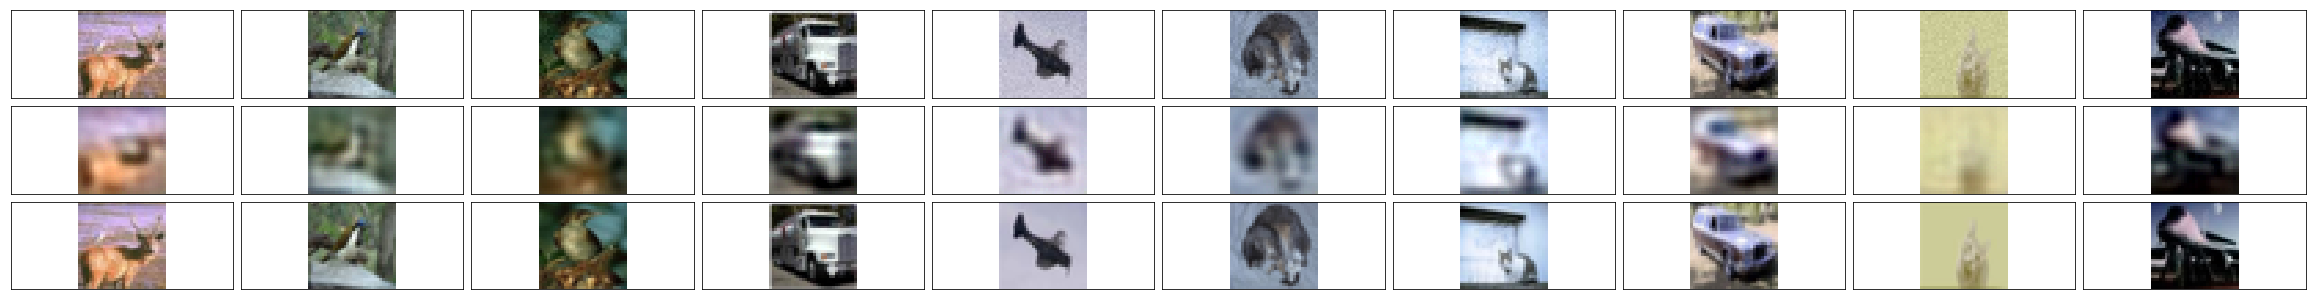

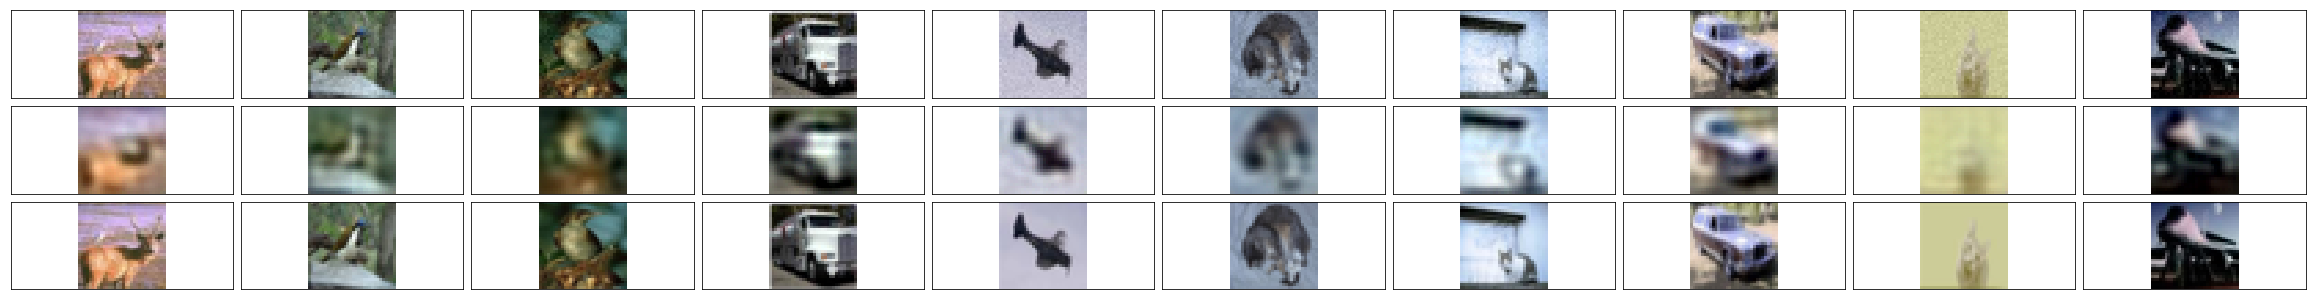

In [10]:
print('Training...')

sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, N_BATCHES + 1):
        for features, noisy_features, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_features, targets_: features})
            
    print("Epoch: {}/{}...".format(e + 1, epochs), "Training loss: {:.4f}".format(batch_cost))
    if e % show_images_every_n_epochs == 0:
        reconstructed = sess.run(y_pred, feed_dict={inputs_: valid_noisy[:10].reshape((10, 32, 32, 3))})
        helper.show_images(valid_features, valid_noisy, np.clip(reconstructed, 0, 1))

### Test the network

Testing...


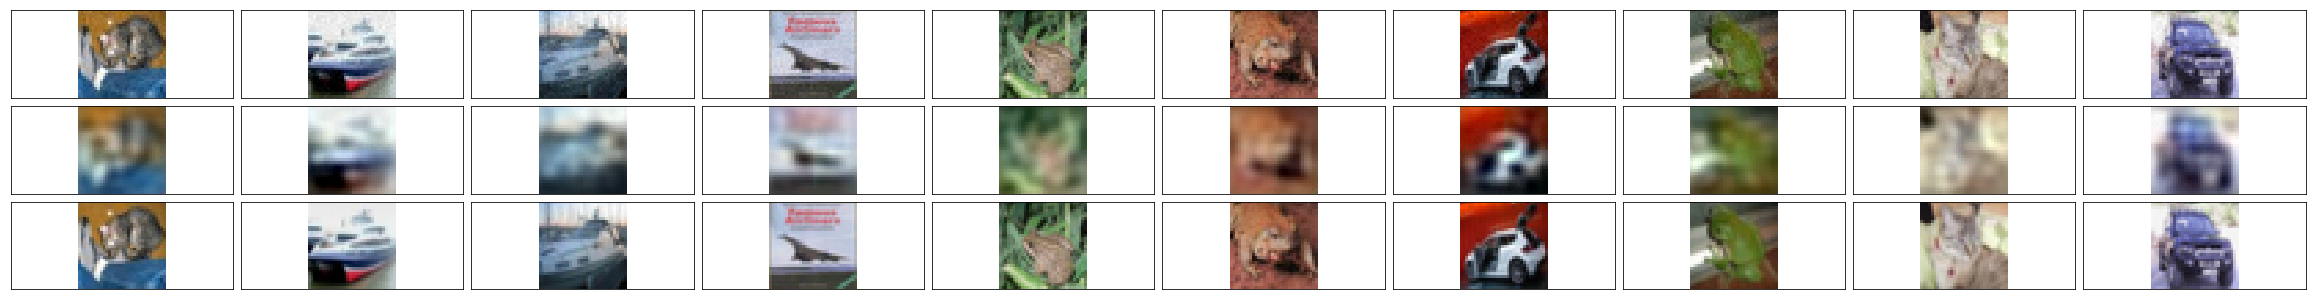

In [11]:
print('Testing...')

test_features = test_features[:10]
test_noisy = test_noisy[:10]

reconstructed = sess.run(y_pred, feed_dict={inputs_: test_noisy.reshape((10, 32, 32, 3))})

helper.show_images(test_features, test_noisy, np.clip(reconstructed, 0, 1))

## Classifier

### Prepare the dataset

In [12]:
helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, int(N_BATCHES * 0.2))

images, _ = helper.load_cfar10_batch(CIFAR_10_DATASET_FOLDER_PATH, random.randint(1, int(N_BATCHES * 0.2)))
valid_features, valid_noisy, valid_labels = helper.load_preprocess_validation()
test_features, test_noisy, test_labels = helper.load_preprocess_testing()

Preprocessing data...
Finished preprocessing


### Train the classifier

In [13]:
print('Training...')

for e in range(epochs):
    for features, _, labels in helper.load_preprocess_training_batch(1, batch_size):
        sess.run(classifier_opt, feed_dict={inputs_: features, labels_: labels, 
                                            keep_prob: keep_probability})
    network_utils.print_stats(e, sess, inputs_, features, labels_, labels, 
                              valid_features, valid_labels, keep_prob, classifier_cost, accuracy)

Training...
Epoch  1:  
('cost: 1.96', 'accuracy: 0.28')
Epoch  2:  
('cost: 1.79', 'accuracy: 0.35')
Epoch  3:  
('cost: 1.66', 'accuracy: 0.40')
Epoch  4:  
('cost: 1.59', 'accuracy: 0.41')
Epoch  5:  
('cost: 1.50', 'accuracy: 0.43')
Epoch  6:  
('cost: 1.40', 'accuracy: 0.44')
Epoch  7:  
('cost: 1.32', 'accuracy: 0.45')
Epoch  8:  
('cost: 1.23', 'accuracy: 0.47')
Epoch  9:  
('cost: 1.14', 'accuracy: 0.49')
Epoch 10:  
('cost: 1.05', 'accuracy: 0.50')
Epoch 11:  
('cost: 1.03', 'accuracy: 0.50')
Epoch 12:  
('cost: 0.99', 'accuracy: 0.51')
Epoch 13:  
('cost: 0.89', 'accuracy: 0.49')
Epoch 14:  
('cost: 0.81', 'accuracy: 0.53')
Epoch 15:  
('cost: 0.74', 'accuracy: 0.53')
Epoch 16:  
('cost: 0.68', 'accuracy: 0.54')
Epoch 17:  
('cost: 0.62', 'accuracy: 0.53')
Epoch 18:  
('cost: 0.55', 'accuracy: 0.55')
Epoch 19:  
('cost: 0.51', 'accuracy: 0.54')
Epoch 20:  
('cost: 0.44', 'accuracy: 0.56')


### Test the classifier

In [16]:
print('Testing...')

test_batch_acc_total = 0
test_batch_count = 0
for test_feature_batch, _, test_label_batch in helper.load_testing_batch(batch_size):
    test_batch_acc_total += sess.run(accuracy, feed_dict={inputs_: test_feature_batch, 
                                                          labels_: test_label_batch, keep_prob: 1.0})
    test_batch_count += 1

print("Testing Accuracy: {:.2f}".format(test_batch_acc_total / test_batch_count))

Testing...
Testing Accuracy: 0.56
